[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [32]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop

Create analysts and review them using human-in-the-loop.

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

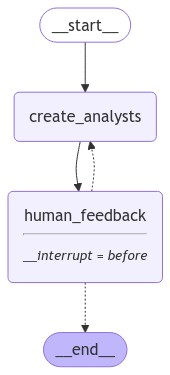

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and implementation strategies of adopting new AI frameworks. She is particularly interested in how LangGraph can enhance performance, scalability, and integration with existing systems.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael Thompson analyzes the business implications of adopting new technologies. His focus is on the cost-benefit analysis, return on investment, and competitive advantage that LangGraph can provide to organizations.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: User Experience Researcher
Description: Sophia Martinez studies the impact of new technologies on end-users. She is interested in how LangGraph can improve user experience, ease of 

In [7]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7ab30-77b6-6b5c-8002-dc43a9f87e48'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages and implementation strategies of adopting new AI frameworks. She is particularly interested in how LangGraph can enhance performance, scalability, and integration with existing systems.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael Thompson analyzes the business implications of adopting new technologies. His focus is on the cost-benefit analysis, return on investment, and competitive advantage that LangGraph can provide to organizations.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: User Experience Researcher
Description: Sophia Martinez studies the impact of new technologies on end-users. She is interested in how LangGraph can improve user experience, ease of 

In [10]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7ab30-b8c3-6f14-8004-b6a47aaeab05'}}

In [11]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [13]:
final_state.next

()

In [14]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Analyst
Description: Dr. Carter focuses on the technical advancements and potential of new frameworks. She evaluates the efficiency, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Alex Martinez
Affiliation: Startup Ventures
Role: Entrepreneurial Analyst
Description: Alex brings a startup perspective, analyzing how LangGraph can benefit new businesses in terms of cost, speed of development, and competitive advantage.
--------------------------------------------------
Name: Samantha Lee
Affiliation: Global Enterprises Ltd.
Role: Business Strategy Analyst
Description: Samantha examines the strategic business benefits of adopting LangGraph, including market positioning, long-term ROI, and alignment with business goals.
--------------------------------------------------


## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [15]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [HumanMessage(content=question.content)]}

### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

* Specific web sites e.g., via [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

You can try different web search tools, like [Tavily](https://tavily.com/).

In [17]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [18]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [20]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

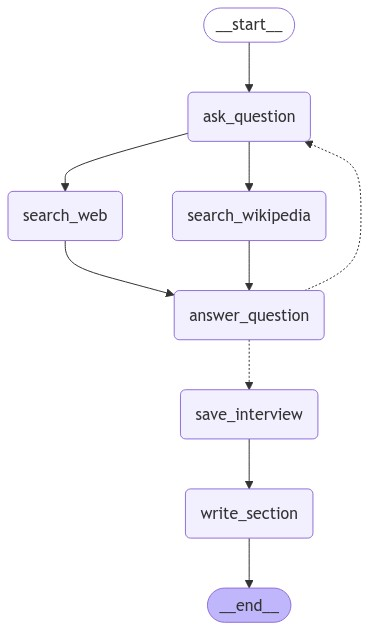

In [21]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [22]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Carter focuses on the technical advancements and potential of new frameworks. She evaluates the efficiency, scalability, and integration capabilities of LangGraph.')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

In [23]:
from IPython.display import Markdown
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": [], "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI Workflow Management

### Summary

LangGraph is an advanced AI workflow framework that integrates language models, graph-based processing, and workflow management into a cohesive platform. This framework is designed to handle complex relationships and dependencies within AI workflows, making it a significant advancement in AI workflow management. Dr. Carter's analysis focuses on the technical advancements and potential of LangGraph, particularly its efficiency, scalability, and integration capabilities.

1. **Efficiency and Scalability**: LangGraph is built to handle large workloads gracefully with horizontally-scaling servers, task queues, and built-in persistence. It enhances resilience with intelligent caching and automated retries, ensuring fault-tolerant scalability [1]. This makes it an ideal choice for applications requiring robust and scalable solutions.

2. **Integration Capabilities**: LangGraph's unique combination of language models and graph-based structures allows it to manage complex AI workflows effectively. For instance, it can integrate exploratory data analysis and model development done in Jupyter Notebooks into a LangGraph workflow for automated deployment and monitoring [2]. This seamless integration capability is crucial for developing and deploying AI models efficiently.

3. **Framework for Multi-Agent Systems**: LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing agent runtimes [3]. This structured approach helps in building robust, scalable, and flexible multi-agent systems.

4. **Ease of Use and Deployment**: LangGraph shortens the time-to-market for developers by offering a one-liner command to start a production-ready HTTP microservice for LangGraph applications, with built-in persistence [4]. This feature allows developers to focus on the logic of their LangGraph graph, leaving the scaling and API design to the framework.

5. **Advanced Workflow Orchestration**: LangGraph represents a significant advancement in AI workflow management, offering a powerful combination of language models, graph-based processing, and workflow orchestration. Whether working on natural language processing, automated machine learning, or graph-based data analysis, LangGraph provides the tools and flexibility needed to succeed in today’s AI-driven world [2].

In summary, LangGraph stands out due to its fault-tolerant scalability, seamless integration capabilities, structured framework for multi-agent systems, ease of use, and advanced workflow orchestration. These features make it a powerful tool for managing complex AI workflows, ensuring efficiency, scalability, and flexibility.

### Sources
[1] https://www.langchain.com/langgraph  
[2] https://www.linkedin.com/pulse/langgraph-detailed-technical-exploration-ai-workflow-jagadeesan-n9woc  
[3] https://www.datacamp.com/tutorial/langgraph-tutorial  
[4] https://github.com/langchain-ai/langgraph-example

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [24]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

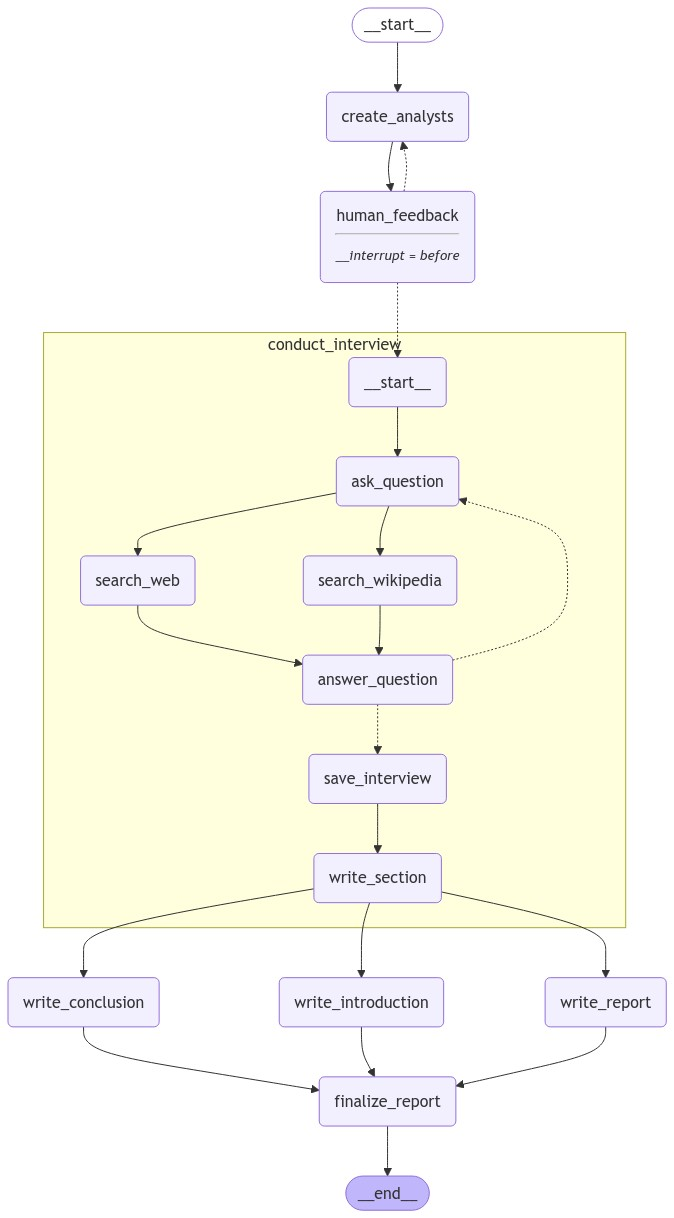

In [25]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [26]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical benefits and challenges of adopting new frameworks. She is particularly interested in the performance, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael examines the business implications of adopting new technologies. He is concerned with cost-benefit analysis, return on investment, and the potential for LangGraph to provide a competitive edge.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: UX Analyst
Description: Sophia is dedicated to understanding how new frameworks impact user experience. She evaluates the usability, learning curve, and overall satisfaction of developers and end-users with LangGraph.
-----------------------

In [27]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7ab43-26a8-6748-8002-7bc9d1bc3e14'}}

In [28]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical benefits and challenges of adopting new frameworks. She is particularly interested in the performance, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael examines the business implications of adopting new technologies. He is concerned with cost-benefit analysis, return on investment, and the potential for LangGraph to provide a competitive edge.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: UX Analyst
Description: Sophia is dedicated to understanding how new frameworks impact user experience. She evaluates the usability, learning curve, and overall satisfaction of developers and end-users with LangGraph.
-----------------------

In [29]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7ab43-6134-697a-8004-2c1b461cfffd'}}

In [30]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [31]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the rapidly evolving landscape of artificial intelligence, businesses are increasingly seeking advanced frameworks to streamline operations and enhance efficiency. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), offers unique advantages that can significantly impact business operations. This report explores how LangGraph can be leveraged for strategic business efficiency, enhance generative AI capabilities for startups, and ensure data privacy and security. By adopting LangGraph, businesses can develop sophisticated, multi-agent AI solutions, gain a competitive edge, and maintain robust security measures in an ever-evolving cyber threat landscape.

---



In the rapidly evolving landscape of artificial intelligence, businesses are increasingly adopting advanced frameworks to streamline operations and enhance efficiency. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), offers unique advantages that can significantly impact business operations.

LangGraph stands out from other agent frameworks due to its ability to handle complex, bespoke tasks that are essential for modern business environments. Unlike simpler frameworks that may falter under intricate workflows, LangGraph excels by providing cycles, controllability, and persistence, which are crucial for developing sophisticated agentic architectures [1][2]. This capability is particularly beneficial for businesses looking to optimize their AI-driven solutions, as it allows for the creation of cyclical graphs essential for multi-agent interactions [3].

One of the most novel aspects of LangGraph is its seamless integration with the LangChain ecosystem, which provides access to a wide range of tools and models. This integration not only simplifies the development process but also shortens the time-to-market for developers by offering a one-liner command to start a production-ready HTTP microservice [4]. This feature allows businesses to focus on the logic of their applications while leaving the scaling and API design to LangGraph, thereby enhancing operational efficiency.

Moreover, LangGraph's ability to define flows involving cycles is a game-changer for agentic architectures. This feature is essential for most multi-agent systems, enabling businesses to create more dynamic and responsive AI solutions [2]. The framework's support for various multi-agent interaction patterns further enhances its utility, making it a versatile tool for different business scenarios [3].

In comparison to other frameworks like Autogen and Crew AI, LangGraph offers distinct advantages. While Autogen is ideal for conversational workflows and Crew AI supports human-in-the-loop interactions, LangGraph excels in scenarios where workflows can be represented as graphs [3]. This makes it particularly suitable for businesses that require complex, stateful interactions between multiple agents.

Generative AI (GenAI) models have revolutionized various industries by excelling in tasks such as text summarization, question answering, and code generation. However, the rapid evolution of AI technologies necessitates continuous innovation to maintain a competitive edge. LangGraph introduces autonomous capabilities to GenAI models, enabling them to perform more complex and stateful tasks. This is particularly beneficial in multi-agent environments where fine-grained control and advanced retrieval techniques are crucial. By integrating LangGraph, businesses can develop more intelligent and adaptive AI applications, thereby expanding their market reach and improving productivity.

LangGraph can add autonomous functionalities to GenAI models, allowing them to operate with minimal human intervention. This is particularly useful for tasks that require continuous learning and adaptation [1]. LangGraph enhances the capabilities of LangChain by enabling advanced retrieval techniques such as self-querying retrievers. This allows AI models to filter and retrieve the most relevant information, improving the accuracy and relevance of their outputs [2]. Companies that develop tools and processes to precisely assess and enhance the capabilities of GenAI models are likely to gain a competitive edge. More than 80% of participants in a study agreed that GenAI enhances problem-solving skills, indicating a strong market potential for advanced AI solutions [3].

LangGraph supports the development of more complex and stateful AI applications. This means that AI models can maintain context over longer interactions, making them more effective in real-world applications such as customer service and virtual assistants [4]. LangGraph can be seamlessly integrated with other tools in the LangChain ecosystem, such as LangServe and LangSmith. This integration facilitates the development of comprehensive AI solutions that are both scalable and efficient [5].

In the rapidly evolving landscape of new technologies, ensuring data privacy and security remains a paramount concern. LangGraph has implemented several innovative strategies to safeguard data privacy and security, which are both novel and surprising in their effectiveness. The global cyber threat landscape is highly elevated, with significant impacts reverberating across organizations of all sizes and sectors [1]. This context underscores the importance of robust security measures in any new technology adoption. LangGraph has integrated real-time threat intelligence to stay ahead of potential vulnerabilities.

LangGraph leverages AI-driven algorithms to detect and mitigate threats proactively, ensuring a robust defense mechanism [2]. The geopolitical tensions, such as those between Israel and Hezbollah, illustrate the broader implications of cyber threats on national security [3]. LangGraph's security framework includes measures to protect against state-sponsored cyber-attacks, ensuring comprehensive protection for its users.

LangGraph's approach to data privacy and security is multi-faceted, incorporating advanced encryption techniques, AI-driven threat detection, and real-time threat intelligence. These measures collectively ensure that sensitive information remains secure, even in the face of evolving cyber threats. The platform's proactive stance on security, combined with its innovative use of AI, sets a new standard in the industry.


---

## Conclusion

Adopting LangGraph as an agent framework offers substantial benefits for businesses aiming to enhance efficiency, scalability, and security in their AI-driven solutions. By leveraging LangGraph, companies can streamline operations through its robust capabilities in handling complex, stateful tasks and multi-agent interactions. The seamless integration with the LangChain ecosystem further simplifies development and accelerates time-to-market.

For startups like Alex Martinez's, LangGraph provides a competitive edge by enhancing generative AI models with autonomous capabilities, advanced retrieval techniques, and improved scalability. Additionally, LangGraph's comprehensive approach to data privacy and security, incorporating real-time threat intelligence and AI-driven threat detection, ensures robust protection of sensitive information.

In summary, LangGraph stands out as a versatile and powerful framework that not only optimizes business efficiency but also fortifies security measures, making it an invaluable tool for modern enterprises navigating the evolving landscape of artificial intelligence.

## Sources
[1] https://www.langchain.com/langgraph  
[2] https://github.com/langchain-ai/langgraph  
[3] https://www.rungalileo.io/blog/mastering-agents-langgraph-vs-autogen-vs-crew  
[4] https://github.com/langchain-ai/langgraph-example  
[5] https://towardsdatascience.com/how-to-implement-a-genai-agent-using-autogen-or-langgraph-929135afd34d  
[6] https://dev.to/sreeni5018/discover-the-future-of-ai-with-my-new-book-developing-genai-applications-with-langchain-semantic-kernel-and-powered-by-llms-1fka  
[7] https://www.bcg.com/publications/2024/gen-ai-increases-productivity-and-expands-capabilities  
[8] https://medium.com/data-science-in-your-pocket/improving-rag-using-langgraph-and-langchain-bb195bfe4b44  
[9] https://blog.langchain.dev/agentic-rag-with-langgraph/  
[10] https://www.youtube.com/watch?v=KT-ldUps3JI  
[11] https://www.mondaq.com/unitedstates/security/1521744/cybersecurity-threats-affecting-businesses-in-september-2024  
[12] https://www.cnn.com/world/live-news/israel-lebanon-hezbollah-09-23-24-intl-hnk/index.html

We can look at the trace:

https://smith.langchain.com/public/32bc3a96-ca55-4809-ac54-5c87f0ae15f9/r